
# Data Exploration

### Load data

In [1]:
%cd ..

/Users/fulco/Desktop/code/recommender-systems-challenge


In [2]:
import numpy as np
import scipy.sparse as sps
from Utils.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
from Recommenders.Recommender_import_list import *
from Recommenders.Recommender_utils import check_matrix
from reader import load_urm, load_icm, load_target
from evaluate import _get_instance
from sklearn import feature_extraction

In [3]:
res_dir = 'result_experiments/csv'
output_root_path = "../result_experiments/"

In [4]:
URM_all = load_urm()

ICM_channel = load_icm("data_ICM_channel.csv", weight=1)
ICM_event = load_icm("data_ICM_event.csv", weight=1)
ICM_genre = load_icm("data_ICM_genre.csv", weight=1)
ICM_subgenre = load_icm("data_ICM_subgenre.csv", weight=1)

ICM_all = sps.hstack([ICM_genre, ICM_subgenre, ICM_channel, ICM_event]).tocsr()
ICMs = [ICM_genre, ICM_subgenre, ICM_channel, ICM_event, ICM_all]

#### Let's take a look at the data

In [5]:
import pandas as pd

In [6]:
data_path = "Data/"

In [7]:
URM_all_dataframe = pd.read_csv(data_path + 'data_train.csv', dtype={0:int, 1:int, 2:int})
URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [8]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction
0,0,53,1
1,0,209,1
2,0,223,1
3,0,249,1
4,0,435,1
5,0,460,1
6,0,652,1
7,0,960,1
8,0,973,1
9,0,1103,1


In [9]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Number of interactions {}".format(n_interactions))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 18059, Number of users	 13650
Max ID items	 18058, Max Id users	 13649

Number of interactions 5285664
Average interactions per user 387.23
Average interactions per item 292.69

Sparsity 97.86 %


In [10]:
user_interactions = URM_all_dataframe.groupby("UserID").sum("Interaction")['Interaction']

In [11]:
np.median(user_interactions)

340.0

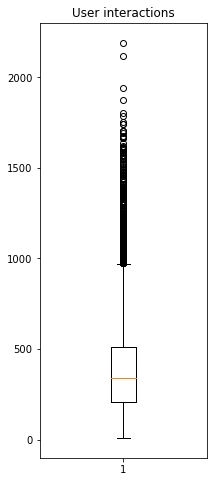

In [11]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
fig1.set_size_inches(3, 8)

ax1.set_title('User interactions')
ax1.boxplot(user_interactions);

## Items interactions


Evaluate how many users interacted with the items

In [12]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([ 14, 156,  49, ..., 458,  48,  98], dtype=int32)

In [13]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    3,     3,     3, ..., 10109, 10118, 11199], dtype=int32)

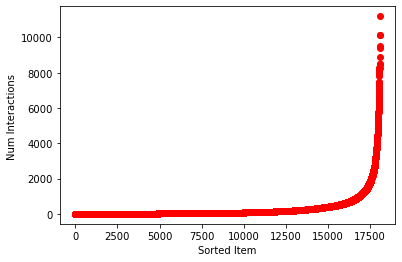

In [14]:
import matplotlib.pyplot as pyplot

pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [15]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 292.69
Average per-item interactions for the top 10% popular items 1847.99
Average per-item interactions for the least 10% popular items 9.60
Average per-item interactions for the median 10% popular items 65.58


In [16]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


## User interactions

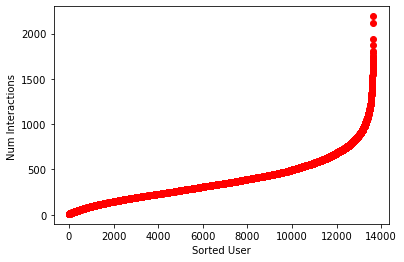

In [17]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

In [18]:
np.sum(np.ediff1d(URM_all.indptr) < 9)

0

### There are no empty profiles or items, and indexes already start from *0*


In [19]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 18059, Number of users	 13650
Max ID items	 18058, Max Id users	 13649

Average interactions per user 387.23
Average interactions per item 292.69

Sparsity 97.86 %


#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [20]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<13650x18059 sparse matrix of type '<class 'numpy.int64'>'
	with 5285664 stored elements in COOrdinate format>

In [21]:
#URM_all.tocsr()

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

In [22]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([ 14, 156,  49, ..., 458,  48,  98], dtype=int32)

In [23]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    3,     3,     3, ..., 10109, 10118, 11199], dtype=int32)

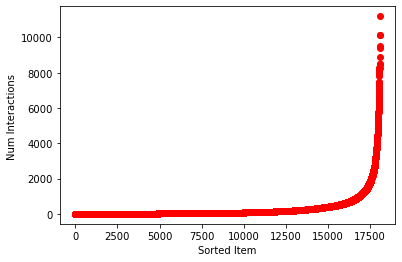

In [24]:
import matplotlib.pyplot as pyplot

pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

x axis is index of array (monotonic because it is sorted), y axis value of element with corresponding x

In [25]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 292.69
Average per-item interactions for the top 10% popular items 1847.99
Average per-item interactions for the least 10% popular items 9.60
Average per-item interactions for the median 10% popular items 65.58


In [26]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

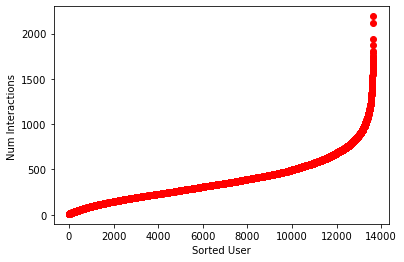

In [27]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()